In [9]:
import json
import pandas as pd
import seaborn as sns
import im2gps.services.localisation as localisation
from im2gps.data.descriptors import DescriptorsTable
from im2gps.lib.localisation import build_index
from im2gps.conf.config import load_config

In [2]:
cfg = load_config(["config-local.yaml"])
path_to_db = cfg.data.datasets.train
path_to_queries = cfg.data.datasets.validation_queries

db = DescriptorsTable(path_to_db, 2048)
val_queries = DescriptorsTable(path_to_queries, 2048)

In [3]:
index=build_index(db)
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fbc6ca56990> >

# Chosing best parametrs for KDE

In [21]:
def grid_search(grid, queries):
    results = {}
    for k in grid['k']:
        results[k] = {}
        for sigma in grid['sigma']:
            print(f"k={k}, sigma={sigma}")
            acc, err, _ = localisation.run_test(index, db,queries,k,loc_type='kde', sigma=sigma, m=5)
            results[k][sigma] = {'acc': acc, 'err':err}
    return results

In [ ]:
grid = {'k':[10, 20, 30, 40, 50, 60, 80 ,100], 
        'sigma': [0.00001, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01]}

results = grid_search(grid)
with open('output/kde_val_results.json', 'w') as f:
    json.dump(results, f)

In [ ]:
header = ['acc', 'scale', 'k', 'sigma']

with open('output/kde_val_results.json','r') as f:
    results = json.load(f)

data =[]
for k in results:
    for sigma in results[k]:
        for scale in results[k][sigma]['acc']:
            row = [results[k][sigma]['acc'][scale], scale,k,sigma]
            data.append(row)
data = pd.DataFrame(data, columns=header)

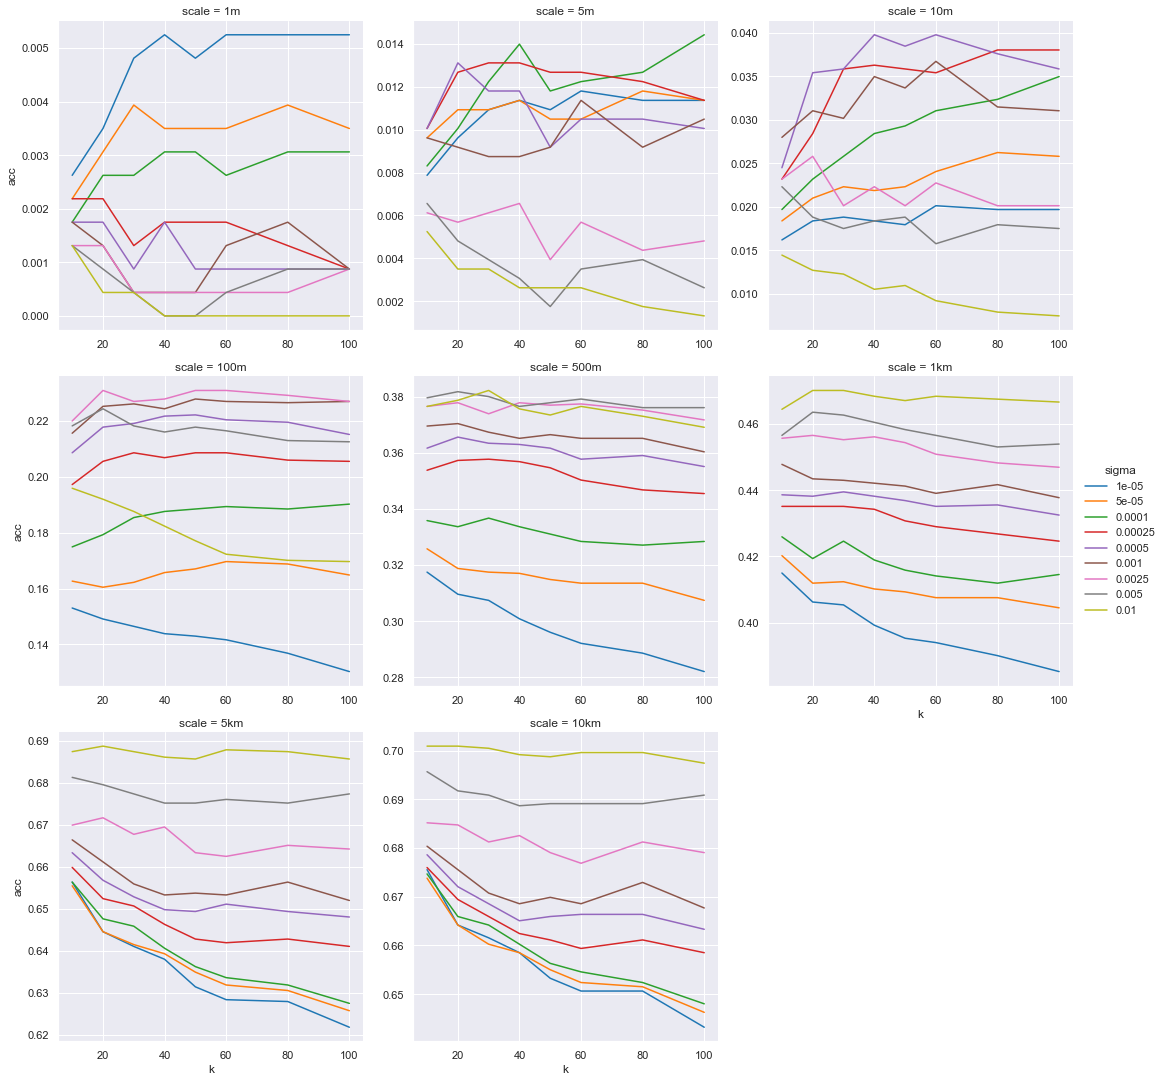

In [38]:
sns.set_style('darkgrid')
sns.relplot(
    data=data,
    x='k', y='acc', col='scale', hue='sigma', marker
    kind='line', palette=sns.color_palette('tab10',9), col_wrap=3, facet_kws={'sharey':False, 'sharex':False}
)

## Best params for different scales
for 500m+ scale good option seems like sigma=0.01 and k=30

for 100m scale sigma=0.0025 and k=20

for 10m scale sigma=0.0005 and k=40

for 5m scale sigma=0.0001 and k=30

for 1m scale sigma=0.00001 and k=40

In [4]:
val_queries.close()

# Comparison of different methods

In [5]:
path_to_queries = cfg.data.datasets.test_queries
test_queries = DescriptorsTable(path_to_queries, 2048)

In [6]:
k=1
acc_1nn,err_1nn,geo_err_1nn = localisation.run_test(index, db,test_queries,k,loc_type='1nn')
print(json.dumps(acc_1nn,indent=2))
print(json.dumps(err_1nn,indent=2))

{
  "1m": 0.0026030368763557484,
  "5m": 0.00824295010845987,
  "10m": 0.024295010845986984,
  "100m": 0.17787418655097614,
  "500m": 0.36789587852494576,
  "1km": 0.4789587852494577,
  "5km": 0.7097613882863341,
  "10km": 0.721475054229935
}
{
  "0m to 1m": 0.00012972759364718236,
  "1m to 5m": 0.003949456612889587,
  "5m to 10m": 0.007582786117945228,
  "10m to 100m": 0.046833975653063034,
  "100m to 500m": 0.26209035252141205,
  "500m to 1km": 0.7248146944410977,
  "1km to 5km": 2.0163013165913397,
  "5km to 10km": 6.9423999442971285,
  "10km+": 578.8564928880315
}


In [7]:
k=30
sigma=0.00025
acc_kde, err_kde, geo_err_kde = localisation.run_test(index, db,test_queries,k,loc_type='kde', sigma=sigma, m=5)
print(json.dumps(acc_kde,indent=2))
print(json.dumps(err_kde,indent=2))

{
  "1m": 0.003036876355748373,
  "5m": 0.011279826464208243,
  "10m": 0.0386117136659436,
  "100m": 0.23947939262472884,
  "500m": 0.41301518438177875,
  "1km": 0.502819956616052,
  "5km": 0.6984815618221258,
  "10km": 0.7149674620390456
}
{
  "0m to 1m": 0.00033563299863847605,
  "1m to 5m": 0.003728099033201593,
  "5m to 10m": 0.007562908724620037,
  "10m to 100m": 0.041182616814178494,
  "100m to 500m": 0.25893732996974117,
  "500m to 1km": 0.7202367594804596,
  "1km to 5km": 1.9922613168710657,
  "5km to 10km": 7.232982308312468,
  "10km+": 550.5770981730524
}


In [12]:
with open('output/image-densities.json','r') as f:
    densities = json.load(f)

header = ['density', 'dist_err']
data = [[dens,err] for dens, err in zip(densities,geo_err_1nn)]
dens_1nn = pd.DataFrame(data, columns=header)
data = [[dens,err] for dens, err in zip(densities,geo_err_kde)]
dens_kde = pd.DataFrame(data, columns=header)

In [20]:
dens_1nn.describe()

,density,dist_err
count,2305.000000,2305.000000
mean,29645.695879,161.910302
std,28232.105777,954.340974
min,1.000000,0.000000
25%,837.000000,0.202896
50%,20520.000000,1.122213
75%,61522.000000,43.510618
max,74874.000000,16990.267617


In [21]:
dens_kde.describe()

,density,dist_err
count,2305.000000,2305.000000
mean,29645.695879,157.559565
std,28232.105777,859.776042
min,1.000000,0.000000
25%,837.000000,0.108498
50%,20520.000000,0.961025
75%,61522.000000,51.668209
max,74874.000000,16685.144155


<AxesSubplot:xlabel='dist_err', ylabel='density'>

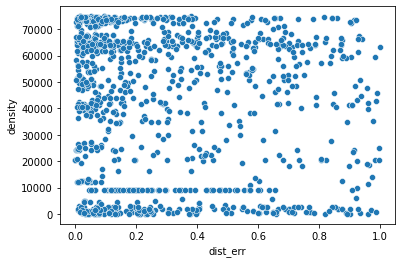

In [29]:
sns.scatterplot(data=dens_1nn[dens_1nn['dist_err']<=10], x="dist_err", y="density")

<AxesSubplot:xlabel='dist_err', ylabel='density'>

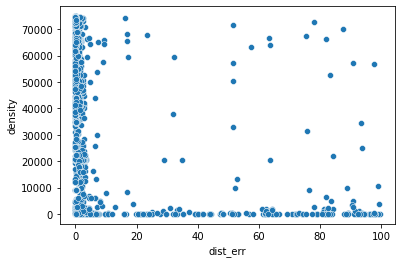

In [27]:
sns.scatterplot(data=dens_kde[dens_kde['dist_err']<=10], x="dist_err", y="density")

In [30]:
db.close()
test_queries.close()